# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomContrast

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping


# Data Exploration

In [2]:
data = pd.read_csv('train.csv')
data.shape

(10407, 4)

In [3]:
num_class = len(data.label.unique())
display("Number of classes:",num_class)

'Number of classes:'

10

In [4]:
base_path = 'dataset/'
diseases = os.listdir(base_path)

label = []
for dis in diseases:
    label.append(dis)

In [5]:
label

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

# Load Data

In [6]:
labels = os.listdir('dataset/')
img_size = 256


train_dataset = image_dataset_from_directory(
    'dataset/',
    image_size = (img_size,img_size),
    batch_size = 64,
    shuffle=True,
    labels='inferred',
    class_names = labels,
    label_mode = 'categorical',
    color_mode='rgb',
    validation_split = 0.1,
    subset='training',
    seed=22
)


val_dataset = image_dataset_from_directory(
    'dataset/',
    image_size = (img_size,img_size),
    batch_size = 64,
    shuffle=False,
    labels='inferred',
    class_names = labels,
    label_mode = 'categorical',
    color_mode='rgb',
    validation_split = 0.1,
    subset='validation',
    seed=22
)

Found 10407 files belonging to 10 classes.
Using 9367 files for training.
Found 10407 files belonging to 10 classes.
Using 1040 files for validation.


In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

# Transfer Learning using MobileNetV3Large

In [8]:
def get_model(base, preprocessor, img_size):    
    inputs = tf.keras.Input(shape=(img_size,img_size,3))
    x = RandomFlip('horizontal')(inputs)
    x = RandomFlip('vertical')(x)
    x = RandomRotation(factor=0.4, fill_mode="wrap")(x)
    x = RandomContrast(factor=0.2)(x)
    x = preprocessor(x)
    x = base(x)

    x = tfl.Flatten()(x)
    x = tfl.Dense(1024, activation='relu')(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(512, activation='relu')(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(128, activation='relu')(x)
    x = tfl.Dropout(0.15)(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(64, activation='relu')(x)
    x = tfl.Dropout(0.3)(x)
    x = tfl.BatchNormalization()(x)
    outputs = tfl.Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    
    return model

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

pre_trained_model = tf.keras.applications.MobileNetV3Large(input_shape=(256,256,3),
                                         include_top=False,
                                         weights='imagenet')

pre_trained_model.trainable = False

In [10]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss',patience=8, verbose=1,  factor=0.4, min_lr=0.0005)
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

In [11]:
model = get_model(pre_trained_model, preprocess_input, img_size)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 random_contrast (RandomCont  (None, 256, 256, 3)      0         
 rast)                                                           
                                                                 
 MobilenetV3large (Functiona  (None, 8, 8, 960)        299635

In [13]:
hist = model.fit(train_dataset,
                 validation_data=val_dataset,
                 epochs=10,
                 verbose=1,
                 callbacks=[early_stop])

Epoch 1/10
147/147 [==============================] - 483s 3s/step - loss: 1.8215 - accuracy: 0.3986 - val_loss: 1.9150 - val_accuracy: 0.3625
Epoch 2/10
147/147 [==============================] - 464s 3s/step - loss: 1.2687 - accuracy: 0.5802 - val_loss: 1.5721 - val_accuracy: 0.4712
Epoch 3/10
147/147 [==============================] - 479s 3s/step - loss: 1.0543 - accuracy: 0.6538 - val_loss: 1.1779 - val_accuracy: 0.5250
Epoch 4/10
147/147 [==============================] - 439s 3s/step - loss: 0.9132 - accuracy: 0.7071 - val_loss: 1.0089 - val_accuracy: 0.6337
Epoch 5/10
147/147 [==============================] - 426s 3s/step - loss: 0.8128 - accuracy: 0.7360 - val_loss: 1.2991 - val_accuracy: 0.5077
Epoch 6/10
147/147 [==============================] - 449s 3s/step - loss: 0.7700 - accuracy: 0.7542 - val_loss: 0.8896 - val_accuracy: 0.6635
Epoch 7/10
147/147 [==============================] - 466s 3s/step - loss: 0.7135 - accuracy: 0.7732 - val_loss: 1.0494 - val_accuracy: 0.6221

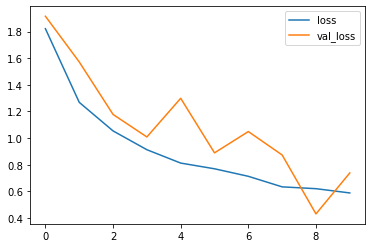

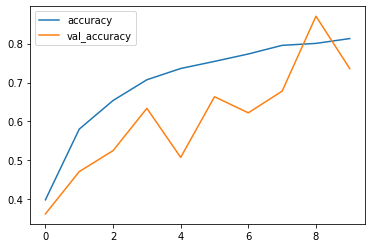

In [14]:
hist = pd.DataFrame(hist.history)
hist.loc[:,['loss','val_loss']].plot()
hist.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

# Predict image using different dataset

In [15]:
predict_img = load_img('data_predict/Tungro/TUNGRO1_001.jpg', target_size = (img_size, img_size))
predict_img = img_to_array(predict_img)
predict_img = np.expand_dims(predict_img, axis = 0)

predict_img2 = load_img('data_predict/Bacterialblight/BACTERAILBLIGHT3_007.jpg', target_size = (img_size, img_size))
predict_img2 = img_to_array(predict_img2)
predict_img2 = np.expand_dims(predict_img2, axis = 0)



pred = model.predict(predict_img)
pred = label[np.argmax(pred)]
print(pred)

pred2 = model.predict(predict_img2)
pred2 = label[np.argmax(pred2)]
print(pred2)

1/1 [==============================] - 1s 1s/step
tungro
1/1 [==============================] - 0s 79ms/step
bacterial_leaf_streak


# Fine tuning the model

In [16]:
print('Number of layers in the MobileNetV3Large Model : ', len(pre_trained_model.layers))

Number of layers in the MobileNetV3Large Model :  263


In [17]:
for layer in pre_trained_model.layers[200:]:
    layer.trainable=True

In [18]:
model_tuned = get_model(pre_trained_model, preprocess_input, img_size)

model_tuned.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [19]:
tuned_hist = model_tuned.fit(train_dataset,
                 validation_data=val_dataset,
                 epochs=15,
                 verbose=1,
                 callbacks=[early_stop])

Epoch 1/15
147/147 [==============================] - 405s 3s/step - loss: 1.6318 - accuracy: 0.4608 - val_loss: 0.7155 - val_accuracy: 0.7952
Epoch 2/15
147/147 [==============================] - 384s 3s/step - loss: 1.0691 - accuracy: 0.6537 - val_loss: 0.6202 - val_accuracy: 0.7885
Epoch 3/15
147/147 [==============================] - 418s 3s/step - loss: 0.8615 - accuracy: 0.7239 - val_loss: 1.1414 - val_accuracy: 0.5548
Epoch 4/15
147/147 [==============================] - 427s 3s/step - loss: 0.7435 - accuracy: 0.7629 - val_loss: 1.0111 - val_accuracy: 0.6231
Epoch 5/15
147/147 [==============================] - 424s 3s/step - loss: 0.6743 - accuracy: 0.7876 - val_loss: 1.2033 - val_accuracy: 0.6010
Epoch 6/15
147/147 [==============================] - 410s 3s/step - loss: 0.5882 - accuracy: 0.8193 - val_loss: 0.9430 - val_accuracy: 0.6529
Epoch 7/15
147/147 [==============================] - 419s 3s/step - loss: 0.5383 - accuracy: 0.8338 - val_loss: 1.4997 - val_accuracy: 0.4875

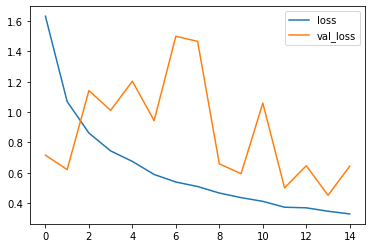

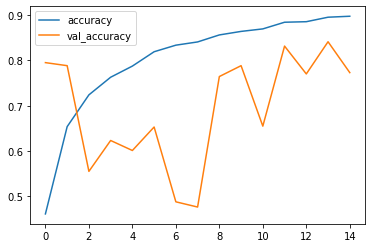

In [20]:
history_tuned = pd.DataFrame(tuned_hist.history)
history_tuned.loc[:,['loss','val_loss']].plot()
history_tuned.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

# Predict image using different dataset

In [21]:
predict_img3 = load_img('data_predict/Tungro/TUNGRO1_009.jpg', target_size = (img_size, img_size))
predict_img3 = img_to_array(predict_img3)
predict_img3 = np.expand_dims(predict_img3, axis = 0)

predict_img4 = load_img('data_predict/Bacterialblight/BACTERAILBLIGHT3_005.jpg', target_size = (img_size, img_size))
predict_img4 = img_to_array(predict_img4)
predict_img4 = np.expand_dims(predict_img4, axis = 0)

pred3 = model_tuned.predict(predict_img)
pred3 = label[np.argmax(pred3)]
print(pred3)

pred4 = model_tuned.predict(predict_img2)
pred4 = label[np.argmax(pred4)]
print(pred4)

1/1 [==============================] - 1s 1s/step
downy_mildew
1/1 [==============================] - 0s 78ms/step
dead_heart
